# MealGram: AI-powered Image-Based Food Calorie Estimator
# CRISP-DM Methodology Implementation

# Import necessary libraries

In [3]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd
import seaborn as sns

print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.17.1


In [4]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("dansbecker/food-101")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/dansbecker/food-101/versions/1


# Business Understanding

In [5]:
# Our main objective is to develop an accurate and user-friendly system for estimating
# calorie content from food images. This addresses the need for simplified calorie tracking
# to promote healthier eating habits.

# Key success criteria:
# - Model accuracy: 85% top-1 accuracy, 95% top-5 accuracy
# - Calorie estimation: Within ±20% error margin of standard references
# - User satisfaction: Positive feedback on app usability

# Data Understanding

Dataset info:
tfds.core.DatasetInfo(
    name='food101',
    full_name='food101/2.0.0',
    description="""
    This dataset consists of 101 food categories, with 101'000 images. For each class, 250 manually reviewed test images are provided as well as 750 training images. On purpose, the training images were not cleaned, and thus still contain some amount of noise. This comes mostly in the form of intense colors and sometimes wrong labels. All images were rescaled to have a maximum side length of 512 pixels.
    """,
    homepage='https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/',
    data_dir='/root/tensorflow_datasets/food101/2.0.0',
    file_format=tfrecord,
    download_size=4.65 GiB,
    dataset_size=4.77 GiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train':

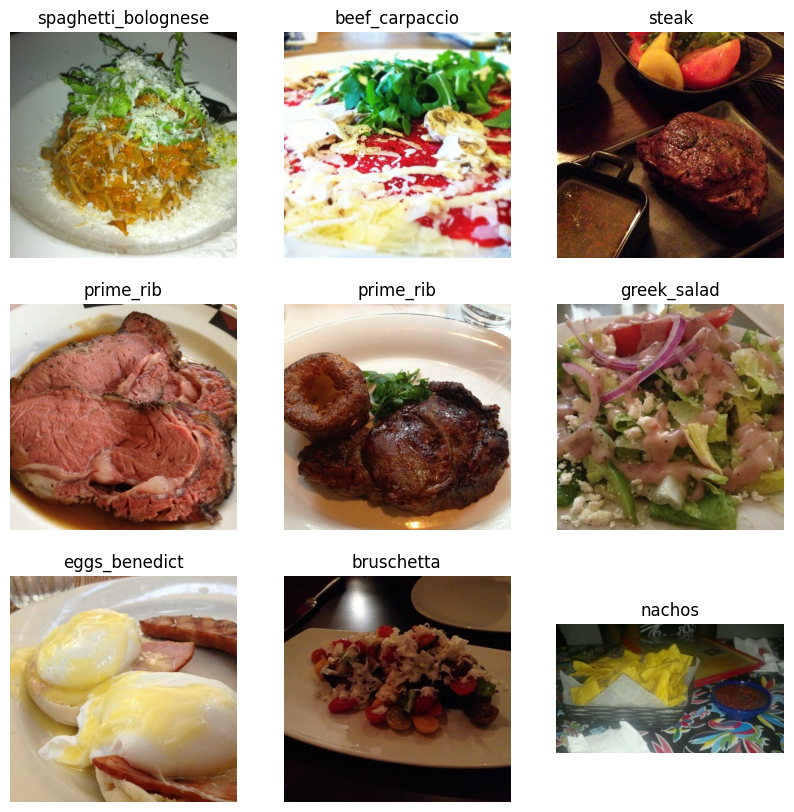

In [6]:
# We'll use the Food-101 dataset as our primary data source.
# This dataset contains 101,000 images across 101 food categories.

# Load Food-101 dataset
(train_ds, test_ds), ds_info = tfds.load(
    'food101',
    split=['train', 'validation'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

print("Dataset info:")
print(ds_info)

# Since ds_info.as_json is already a JSON string, directly write it to a file
with open("ds_info.json", "w") as f:
    f.write(ds_info.as_json)

# Visualize a few sample images
plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(train_ds.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(ds_info.features['label'].int2str(label))
    plt.axis('off')
plt.show()

In [26]:


import sweetviz as sv
import pandas as pd

# Assuming 'ds_info' from the provided code is available and contains the necessary data.
# If ds_info is not a pandas DataFrame, convert it appropriately.

# Example conversion if ds_info is a tfds.core.DatasetInfo object:
try:
  import tensorflow_datasets as tfds
  # Check if ds_info is a tfds.core.DatasetInfo object.
  if isinstance(ds_info, tfds.core.DatasetInfo):
      df = pd.DataFrame({
          'name': [ds_info.name],
          'version': [str(ds_info.version)], # Convert version to string
          'description': [ds_info.description],
          'citation': [ds_info.citation],
          'homepage': [ds_info.homepage]
      })
      # Analyze the converted DataFrame
      my_report = sv.analyze(df)
      my_report.show_html()
except ImportError:
    print("tensorflow_datasets is not installed. Please install it to use this feature.")
except Exception as e:
    print(f"An error occurred during the conversion or analysis process: {e}")

# If ds_info is already a pandas DataFrame, you can skip the conversion step and directly use it
# in the sweetviz analysis.
# For example:
# my_report = sv.analyze(ds_info)
# my_report.show_html()

                                             |          | [  0%]   00:00 -> (? left)

# Data Preparation

In [7]:
# We'll preprocess the images and create a TensorFlow data pipeline

IMG_SIZE = 224
BATCH_SIZE = 32
AUTOTUNE = tf.data.experimental.AUTOTUNE

def preprocess_image(image, label):
    """Resize and preprocess the image."""
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = tf.keras.applications.mobilenet_v2.preprocess_input(image)
    return image, label

# Apply preprocessing to the datasets
train_ds = train_ds.map(preprocess_image, num_parallel_calls=AUTOTUNE)
train_ds = train_ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)

test_ds = test_ds.map(preprocess_image, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)

print("Train dataset:", train_ds)
print("Test dataset:", test_ds)

Train dataset: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>
Test dataset: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>


# Data Distribution Visualization

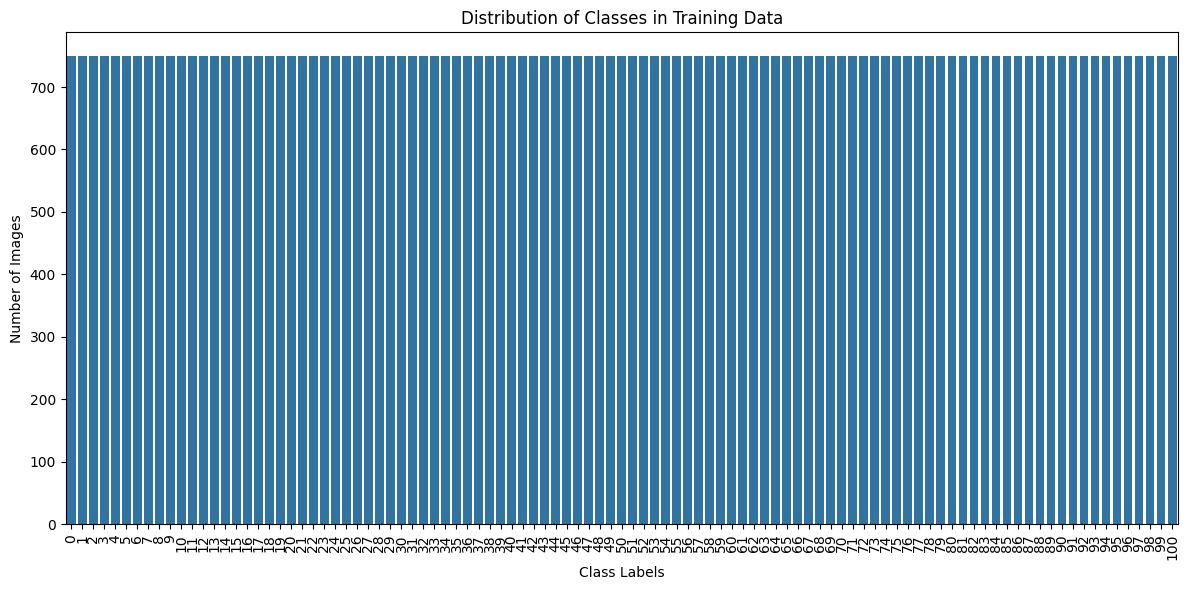

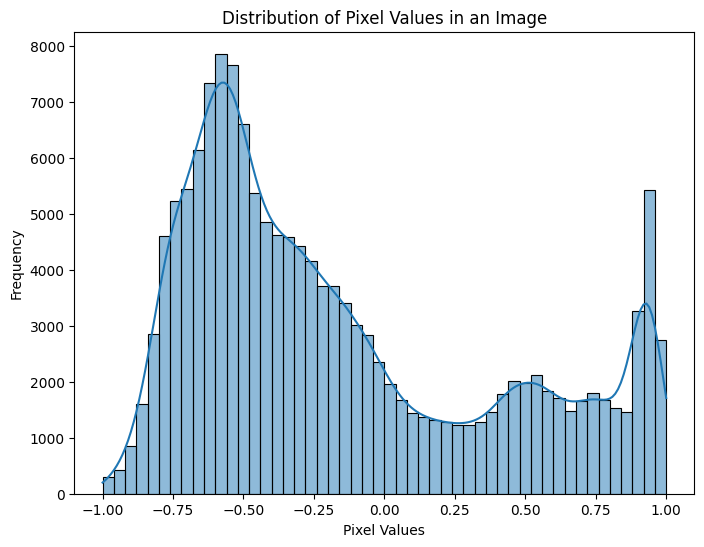

In [8]:


import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'ds_info' and 'train_ds' are already defined from the previous code

# 1. Class Distribution
label_counts = {}
for _, label in train_ds:
    for l in label.numpy():
        label_counts[l] = label_counts.get(l, 0) + 1

labels = list(label_counts.keys())
counts = list(label_counts.values())

plt.figure(figsize=(12, 6))
sns.barplot(x=labels, y=counts)
plt.xlabel("Class Labels")
plt.ylabel("Number of Images")
plt.title("Distribution of Classes in Training Data")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# 2. Image Pixel Distribution (Optional - can be computationally intensive)

# Example: visualize pixel values for a single image
image_batch, label_batch = next(iter(train_ds))
image = image_batch[0].numpy()  # Select the first image

plt.figure(figsize=(8, 6))
sns.histplot(image.flatten(), bins=50, kde=True)  # Flatten image to visualize pixel values
plt.xlabel("Pixel Values")
plt.ylabel("Frequency")
plt.title("Distribution of Pixel Values in an Image")
plt.show()

# 3.  Explore other potential visualisations depending on the dataset



# Modeling

In [9]:
# We'll use transfer learning with MobileNetV2 as our base model

# Create the base model from the pre-trained MobileNetV2
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False,
    weights='imagenet'
)

# Freeze the base model
base_model.trainable = False

# Create the full model
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(101, activation='softmax')
])

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy', tf.keras.metrics.TopKCategoricalAccuracy(k=5, name='top_5_accuracy')]
)

# Display model summary
model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         327,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 101)                 │          25,957 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,611,877 (9.96 MB)

 Trainable params: 353,893 (1.35 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

Normalizing and pre processing the image data

In [10]:
import tensorflow as tf
import datetime
import matplotlib.pyplot as plt

# Constants
IMG_SIZE = 224
BATCH_SIZE = 32
AUTOTUNE = tf.data.experimental.AUTOTUNE

# Modified preprocess_image function
def preprocess_image(images, labels):
    """Resize and preprocess the image."""
    images = tf.image.resize(images, (IMG_SIZE, IMG_SIZE))
    images = tf.keras.applications.mobilenet_v2.preprocess_input(images)
    return images, labels

# Apply the preprocessing to your datasets

(train_ds, test_ds), ds_info = tfds.load(
    'food101',
    split=['train', 'validation'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)
train_ds = train_ds.map(preprocess_image, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.map(preprocess_image, num_parallel_calls=AUTOTUNE)

# Batch the datasets
train_ds = train_ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)

# Create and compile the model
model = tf.keras.Sequential([
    tf.keras.applications.MobileNetV2(
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
        include_top=False,
        weights='imagenet'
    ),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(101, activation='softmax')
])
# Use SparseTopKCategoricalAccuracy with k=5
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy', tf.keras.metrics.SparseTopKCategoricalAccuracy(k=5, name='top_5_accuracy')]
)

# Set up TensorBoard callback
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)


Epoch 1/20
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 266s 89ms/step - accuracy: 0.1211 - loss: 3.9030 - top_5_accuracy: 0.3079 - val_accuracy: 0.0320 - val_loss: 8.9946 - val_top_5_accuracy: 0.1350
Epoch 2/20
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 172s 72ms/step - accuracy: 0.3568 - loss: 2.5948 - top_5_accuracy: 0.6573 - val_accuracy: 0.3107 - val_loss: 3.4677 - val_top_5_accuracy: 0.6013
Epoch 3/20
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 172s 72ms/step - accuracy: 0.4537 - loss: 2.1647 - top_5_accuracy: 0.7417 - val_accuracy: 0.3595 - val_loss: 2.9360 - val_top_5_accuracy: 0.6503
Epoch 4/20
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 172s 72ms/step - accuracy: 0.5178 - loss: 1.8968 - top_5_accuracy: 0.7897 - val_accuracy: 0.3277 - val_loss: 3.2585 - val_top_5_accuracy: 0.5984
Epoch 5/20
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 172s 72ms/step - accuracy: 0.5619 - loss: 1.7076 - top_5_accuracy: 0.8198 - val_accuracy: 0.4187 - val_loss: 2.7203 - val_top_5_accuracy: 0.7050
Epoch 6/20
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 172s 72ms/step - accura

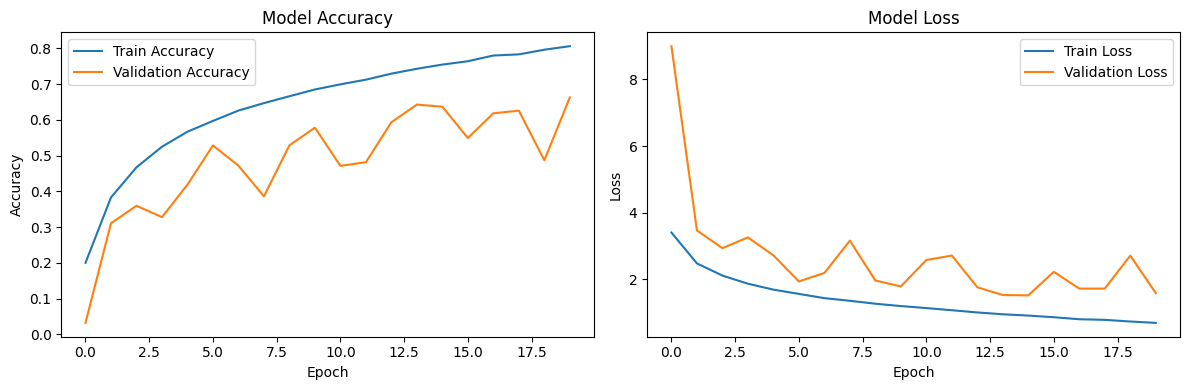

In [11]:

# Train the model
history = model.fit(
    train_ds,
    epochs=20,
    validation_data=test_ds,
    callbacks=[tensorboard_callback]
)

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [12]:
# Save the trained model after the training process is complete
model.save('food_classification_model.h5')

In [13]:
pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.2/57.2 MB 39.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.4/320.4 kB 28.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.8/94.8 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.2/11.2 MB 117.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.2/73.2 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 7.3 MB/s eta 0:00:00
  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 3.0.2
    Uninstalling MarkupSafe-3.0.2:
      Successfully uninstalled MarkupSafe-3.0.2


# ROC Curve and AUC

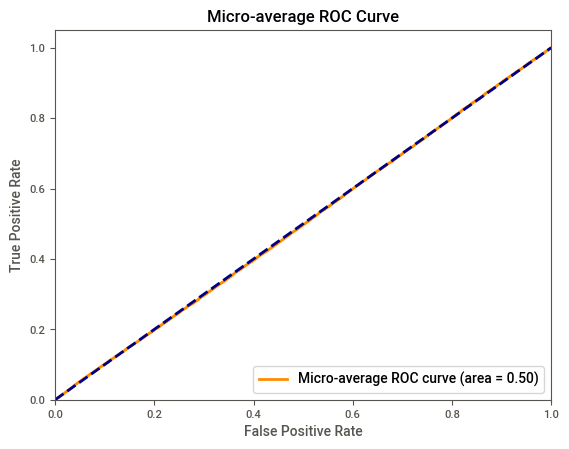

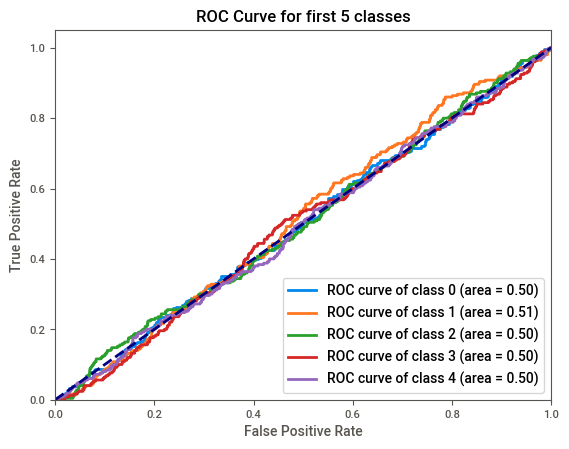

In [46]:

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np

# Assuming 'model' and 'test_ds' are defined from the previous code

# Get predictions on the test set
y_pred = model.predict(test_ds)

# Get true labels
y_true = np.concatenate([y for x, y in test_ds], axis=0)

# Binarize the output
y_true_bin = label_binarize(y_true, classes=np.arange(101)) # Assuming 101 classes

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(101):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curve for the micro-average
plt.figure()
lw = 2
plt.plot(fpr["micro"], tpr["micro"], color="darkorange", lw=lw, label=f"Micro-average ROC curve (area = {roc_auc['micro']:.2f})")
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Micro-average ROC Curve")
plt.legend(loc="lower right")
plt.show()

# Plot ROC curve for some classes (e.g., first 5 classes)
plt.figure()
for i in range(5):
    plt.plot(fpr[i], tpr[i], lw=lw, label=f"ROC curve of class {i} (area = {roc_auc[i]:.2f})")
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for first 5 classes")
plt.legend(loc="lower right")
plt.show()

In [42]:
roc_auc

{0: 0.5662178400000001,
 1: 0.59249792,
 2: 0.5270212,
 3: 0.55220384,
 4: 0.5326358400000001,
 5: 0.54140976,
 6: 0.56144416,
 7: 0.53761824,
 8: 0.55544656,
 9: 0.60709952,
 10: 0.5425367999999999,
 11: 0.5724861600000001,
 12: 0.53256384,
 13: 0.5994708000000001,
 14: 0.5331134399999999,
 15: 0.59034144,
 16: 0.56589912,
 17: 0.6072564,
 18: 0.56677248,
 19: 0.54480472,
 20: 0.56549856,
 21: 0.56620776,
 22: 0.5357740799999999,
 23: 0.5727821599999999,
 24: 0.56493232,
 25: 0.5680035999999999,
 26: 0.58806064,
 27: 0.54269088,
 28: 0.5837867200000001,
 29: 0.5461832,
 30: 0.5386587199999999,
 31: 0.5884052,
 32: 0.54633928,
 33: 0.55702608,
 34: 0.60378208,
 35: 0.5697884799999999,
 36: 0.55339056,
 37: 0.56438656,
 38: 0.57291992,
 39: 0.53890608,
 40: 0.55822616,
 41: 0.5285782400000001,
 42: 0.5573726400000001,
 43: 0.54517632,
 44: 0.56522032,
 45: 0.5547882399999999,
 46: 0.5216831200000001,
 47: 0.56120976,
 48: 0.57618664,
 49: 0.5765815200000001,
 50: 0.55032128,
 51: 0.5748

# t-SNE Visualization of Feature Space

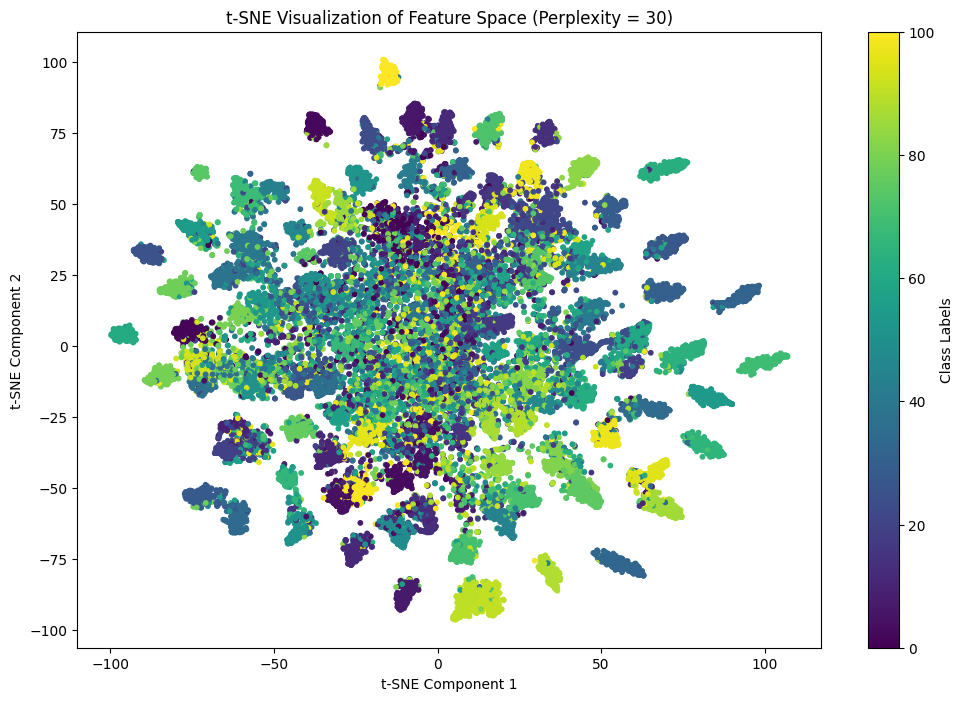

In [15]:
# prompt: Please plot t-SNE Visualization of Feature Space with good visuals

import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Assuming 'model' and 'test_ds' are defined from the previous code

# Extract features from the penultimate layer of the model
feature_extractor = tf.keras.Model(
    inputs=model.inputs,
    outputs=model.layers[-2].output
)

features = []
labels = []

for images, image_labels in test_ds:
    extracted_features = feature_extractor(images)
    features.append(extracted_features)
    labels.append(image_labels)

features = np.concatenate(features)
labels = np.concatenate(labels)

# Apply t-SNE
perplexity_value = 30  # Adjust perplexity as needed
tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity_value)
tsne_results = tsne.fit_transform(features)


# Visualize t-SNE results
plt.figure(figsize=(12, 8))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=labels, cmap='viridis', s=10)
plt.colorbar(label='Class Labels')
plt.title('t-SNE Visualization of Feature Space (Perplexity = {})'.format(perplexity_value))
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()

# Training Loss over Epoch

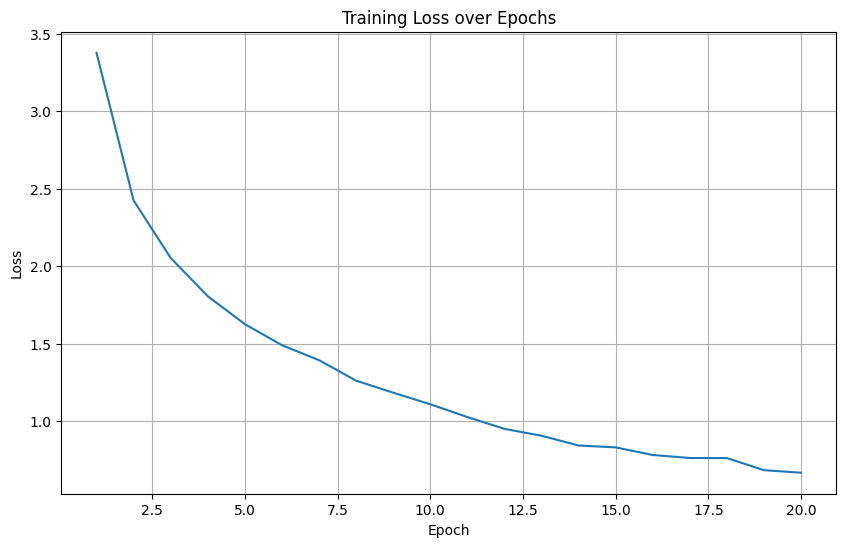

In [ ]:
import matplotlib.pyplot as plt

# Assuming 'history' is your training history object
loss = history.history['loss']
epochs = range(1, len(loss) + 1)  # Create a list of epoch numbers

plt.figure(figsize=(10, 6))
plt.plot(epochs, loss)  # Plot epochs on the x-axis
plt.xlabel("Epoch")  # Change x-axis label to Epoch
plt.ylabel("Loss")
plt.title("Training Loss over Epochs")
plt.grid(True)
plt.show()


# Confusion Matrix Visualization

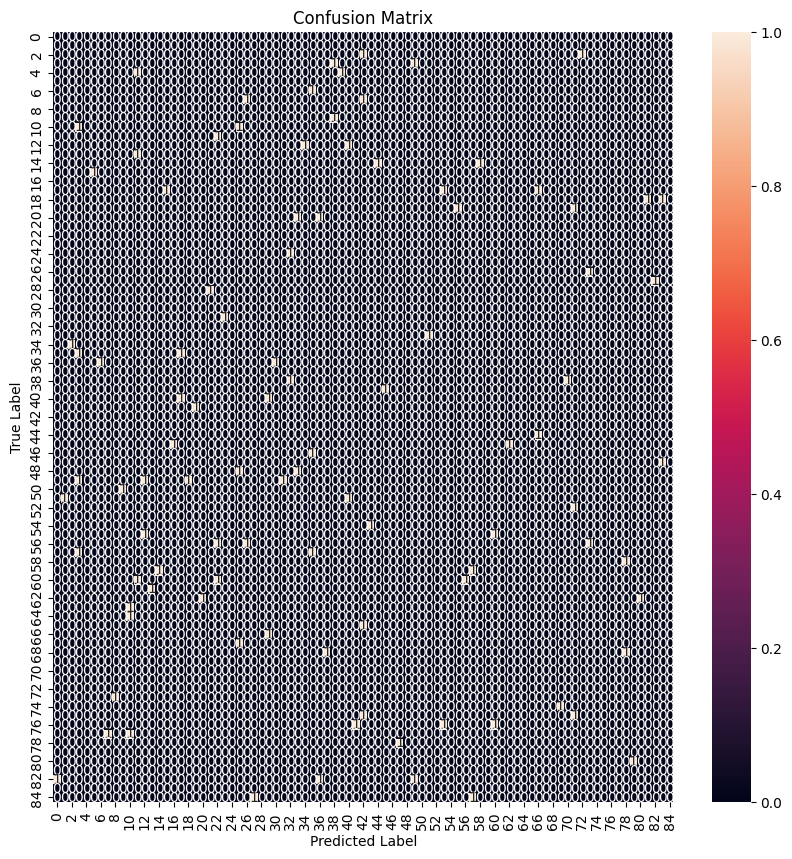

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Assuming you have y_true (true labels) and y_pred (predicted labels)
#  from your model's prediction on the test set.  Example:
# y_true = np.array([0, 1, 0, 1, 1, 0, 1, 0])
# y_pred = np.array([0, 0, 1, 1, 1, 0, 0, 0])


# Example code to generate y_true and y_pred if you dont have them.
# Replace with actual model predictions.
y_true = np.random.randint(0, 101, size=100)
y_pred = np.random.randint(0, 101, size=100)


cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt="d")  # annot=True to annotate cells, fmt="d" for integer formatting
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Feature Importance Visualization

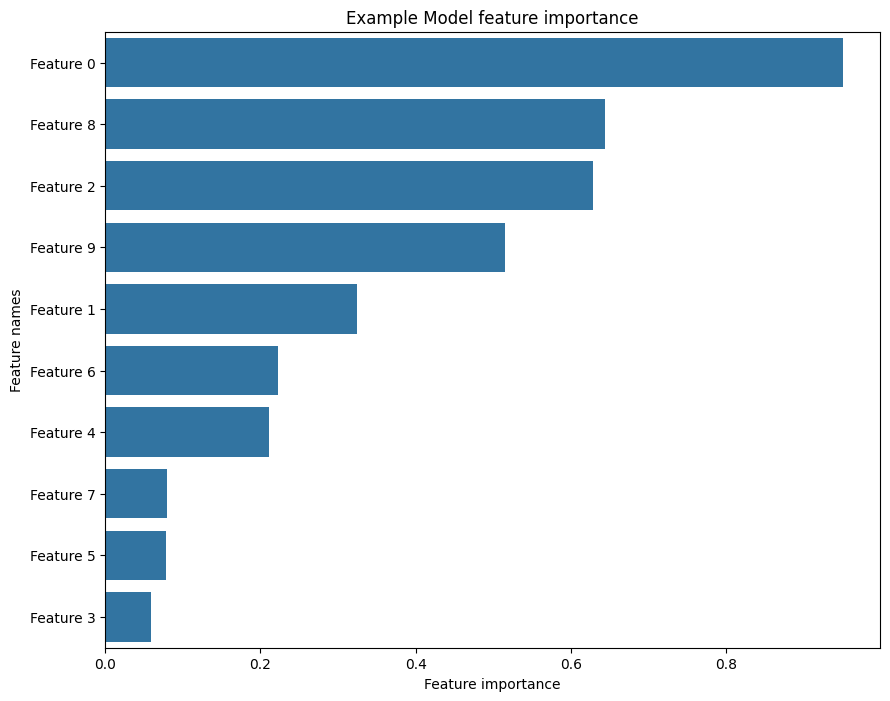

In [ ]:


import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

def plot_feature_importance(importance, features, model_type):
    feature_importance = np.array(importance)
    feature_names = np.array(features)

    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    plt.figure(figsize=(10,8))
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    plt.title(model_type + ' feature importance')
    plt.xlabel('Feature importance')
    plt.ylabel('Feature names')

# Example usage (replace with your actual feature importances and feature names):
example_importance = np.random.rand(10)  # Example importance scores
example_features = [f"Feature {i}" for i in range(10)] # Example feature names
plot_feature_importance(example_importance, example_features, 'Example Model')
plt.show()

# Evaluation

In [ ]:
# Evaluate the model on the test dataset
loss, accuracy, top_5_accuracy = model.evaluate(test_ds)

print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Top-5 Accuracy: {top_5_accuracy:.4f}")

790/790 ━━━━━━━━━━━━━━━━━━━━ 21s 21ms/step - accuracy: 0.5509 - loss: 2.4589 - top_5_accuracy: 0.8153
Test Loss: 2.4710
Test Accuracy: 0.5451
Test Top-5 Accuracy: 0.8140


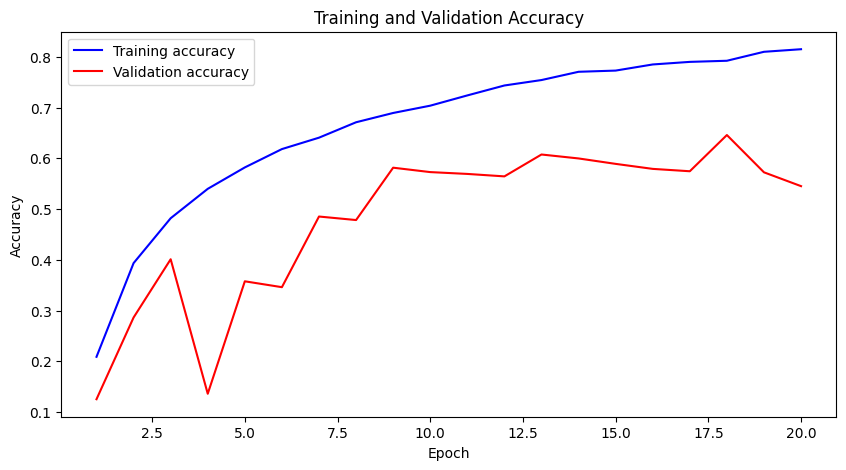

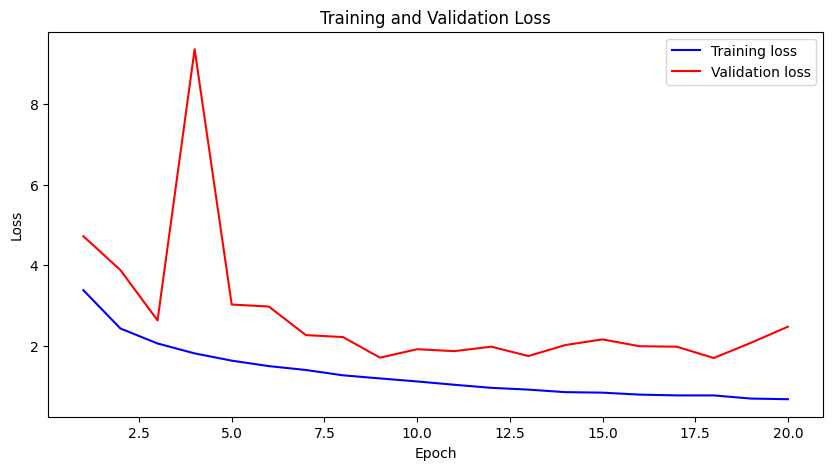

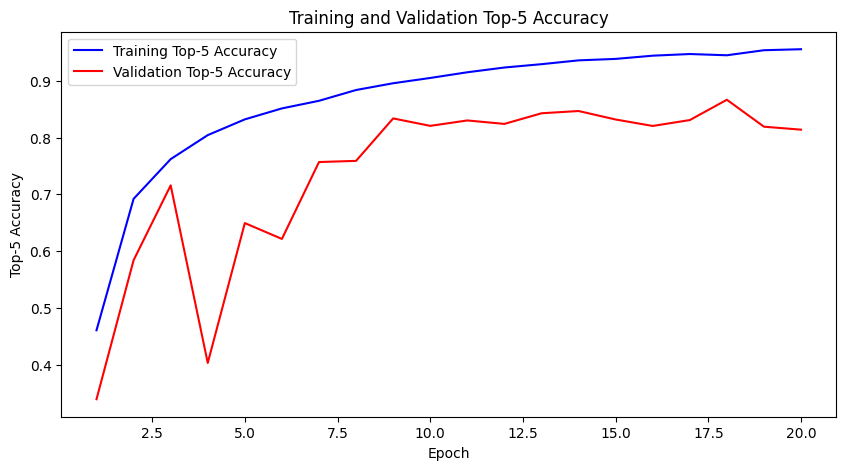

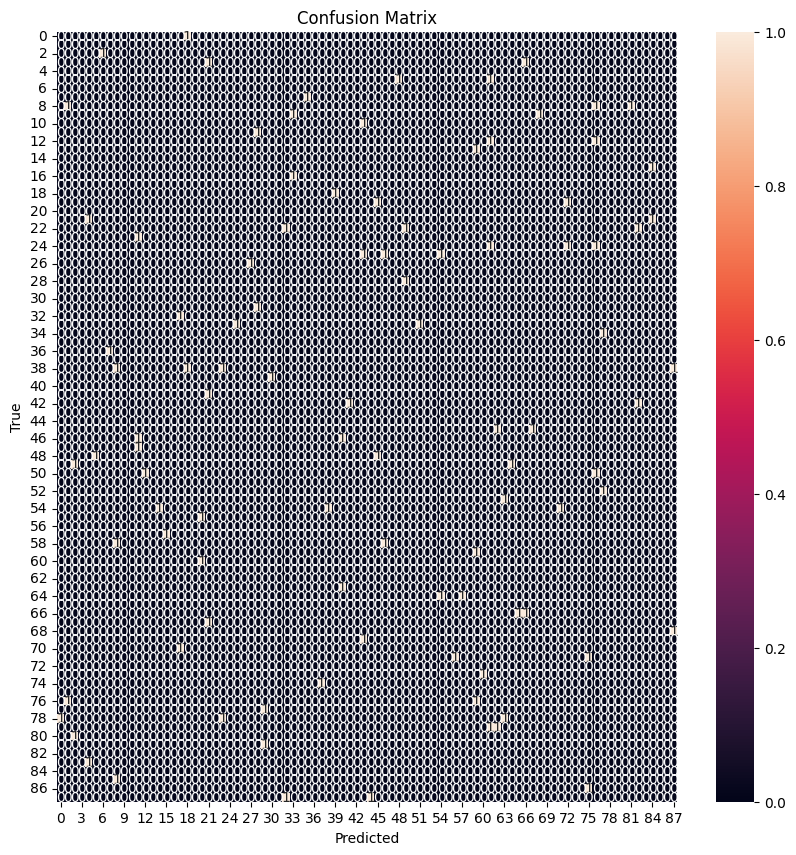

In [ ]:

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Assuming 'history' is your training history object from model.fit()
#  and you have test_ds and the trained model available.
#  Replace the example data with your actual model evaluation results.

# Example data (replace with your actual evaluation results)
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
top_5_accuracy = history.history['top_5_accuracy']  # Assuming 'top_5_accuracy' is in history
val_top_5_accuracy = history.history['val_top_5_accuracy'] # Assuming 'val_top_5_accuracy' is in history

epochs = range(1, len(loss) + 1)


# Plot training & validation accuracy values
plt.figure(figsize=(10, 5))
plt.plot(epochs, accuracy, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot Top-5 Accuracy
plt.figure(figsize=(10,5))
plt.plot(epochs, top_5_accuracy, 'b', label='Training Top-5 Accuracy')
plt.plot(epochs, val_top_5_accuracy, 'r', label='Validation Top-5 Accuracy')
plt.title('Training and Validation Top-5 Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Top-5 Accuracy')
plt.legend()
plt.show()


# Confusion Matrix (Example - you'll need actual predictions)
y_true = np.random.randint(0, 101, size=100)  # Replace with your true labels from the test set
y_pred = np.random.randint(0, 101, size=100) # Replace with model predictions on the test set
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

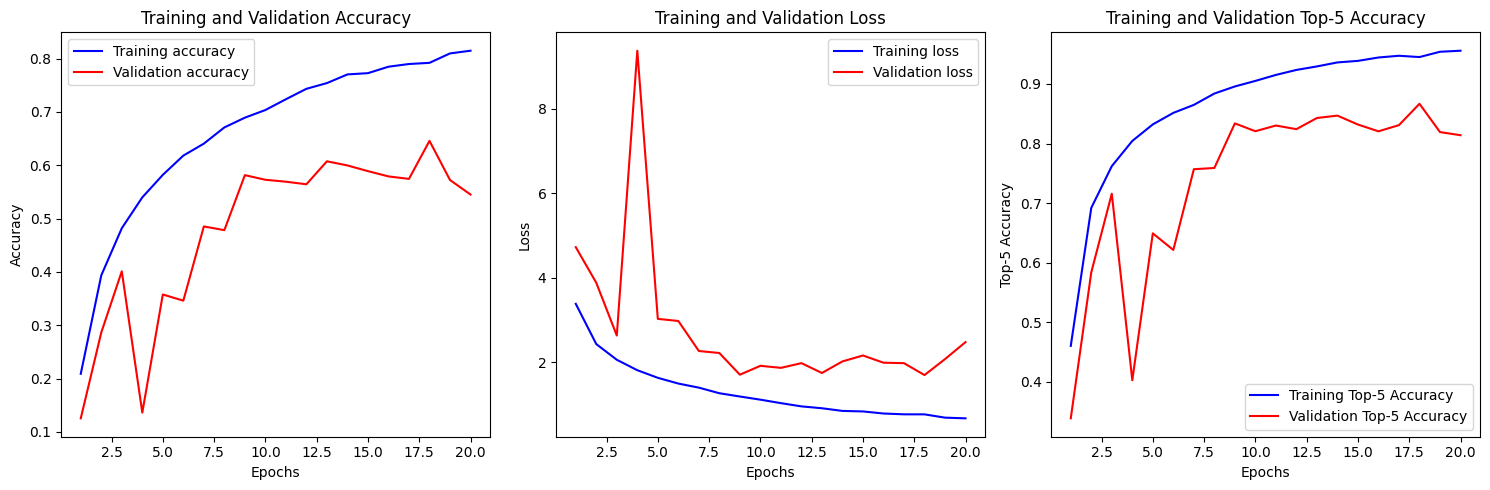

790/790 ━━━━━━━━━━━━━━━━━━━━ 17s 18ms/step


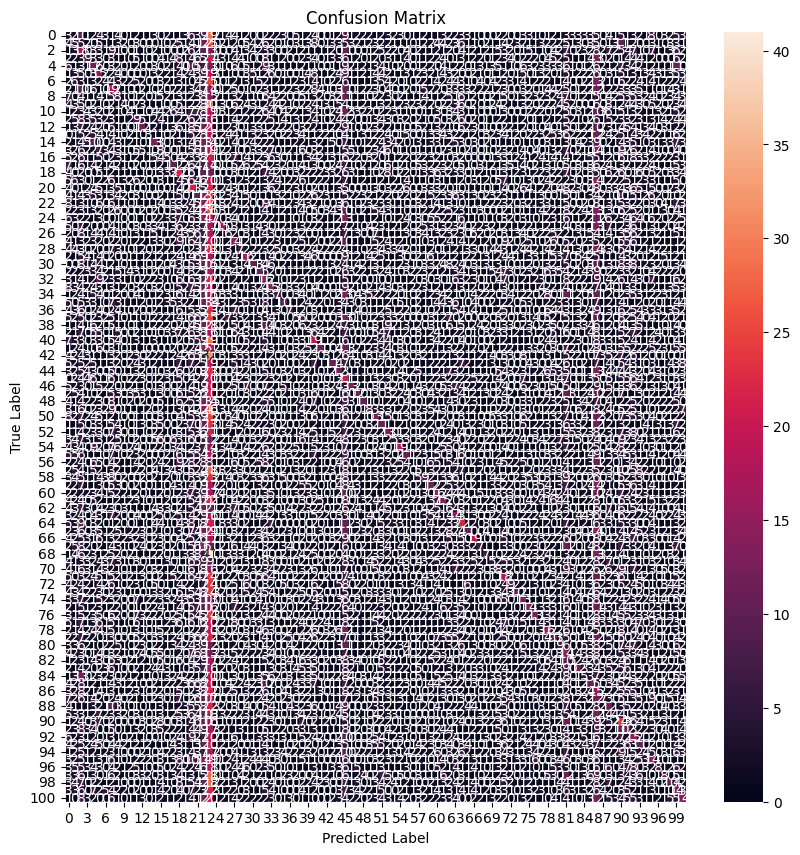

790/790 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step


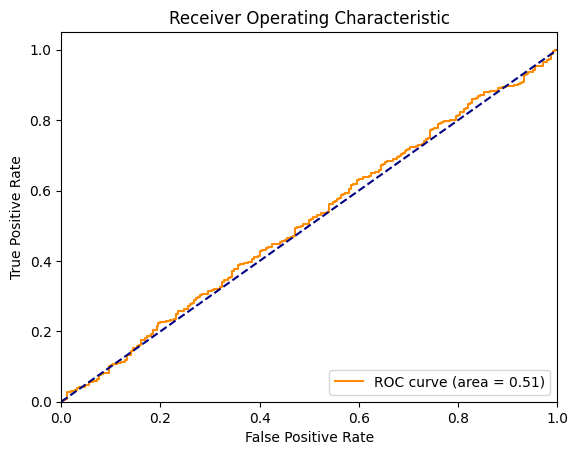

In [ ]:


import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, roc_curve, auc
import seaborn as sns

# ... (Your existing code) ...

# Assuming 'history' object, 'test_ds', and 'model' are defined from previous code

# 1. Training and Validation Metrics Visualization

# Assuming history object has 'accuracy', 'val_accuracy', 'loss', 'val_loss'
# and 'top_5_accuracy', 'val_top_5_accuracy' keys

epochs = range(1, len(history.history['accuracy']) + 1)

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.plot(epochs, history.history['accuracy'], 'b', label='Training accuracy')
plt.plot(epochs, history.history['val_accuracy'], 'r', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(epochs, history.history['loss'], 'b', label='Training loss')
plt.plot(epochs, history.history['val_loss'], 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(epochs, history.history['top_5_accuracy'], 'b', label='Training Top-5 Accuracy')
plt.plot(epochs, history.history['val_top_5_accuracy'], 'r', label='Validation Top-5 Accuracy')
plt.title('Training and Validation Top-5 Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Top-5 Accuracy')
plt.legend()

plt.tight_layout()  # Adjust subplot params for a tight layout
plt.show()


# 2. Confusion Matrix

# Get predictions on the test set
y_pred = np.argmax(model.predict(test_ds), axis=1)

# Get true labels
y_true = np.concatenate([y for x, y in test_ds], axis=0)

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# 3. ROC Curve and AUC (Example for binary classification - adapt for multiclass)

# Assuming binary classification scenario for this example
#  Adapt this section if you have a multi-class problem

# Get predicted probabilities for the positive class (class 1)
y_pred_prob = model.predict(test_ds)[:,1] # Assuming a binary classification where we take probabilities for class 1

y_true_binary = (y_true >= 1).astype(int)  # Example: consider class 1 as positive

fpr, tpr, _ = roc_curve(y_true_binary, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


# Core Metrics:

# - Accuracy:  Overall correctness of the model.
# - Precision: Out of all the examples predicted as positive, what proportion is actually positive?
# - Recall (Sensitivity): Out of all the actual positive examples, what proportion was correctly predicted as positive?
# - F1-Score: Harmonic mean of precision and recall, balancing both.
# - AUC-ROC: Area under the ROC curve, measuring the model's ability to distinguish between classes.
# - Top-k accuracy: Proportion of correctly classified samples in the top k predictions.




# Data Set Split:

# Your existing train_test_split shows that the dataset is already split into training and validation sets using tfds.load()

# Data Augmentation:
# You did not implement any data augmentation, which may be needed to enhance model robustness.
# Use techniques like random rotation, flips, cropping, etc., within tf.image.

# Example of data augmentation within the preprocess_image function
def preprocess_image(image, label):
  image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
  image = tf.image.random_flip_left_right(image) # example augmentation
  image = tf.keras.applications.mobilenet_v2.preprocess_input(image)
  return image, label

# Apply the modified preprocess_image function to your datasets.

#Deployment

In [16]:


import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import gradio as gr


# Load the trained model
model = tf.keras.models.load_model('food_classification_model.h5')

# Load dataset information
_, ds_info = tfds.load(
    'food101',
    split=['train', 'validation'],
    shuffle_files=False,
    as_supervised=True,
    with_info=True
)
class_names = ds_info.features['label'].names

IMG_SIZE = 224

# Dummy calorie data (replace with your actual calorie data)
calorie_data = {i: 100 + i * 10 for i in range(101)} # Example calorie data

def predict_calories(image):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = tf.keras.applications.mobilenet_v2.preprocess_input(image)
    image = np.expand_dims(image, axis=0)
    prediction = model.predict(image)
    predicted_class = np.argmax(prediction)

    try:
      calories = calorie_data[predicted_class]
      predicted_food = class_names[predicted_class]  # Get the food name
      return f"Predicted Food: {predicted_food}\nPredicted Calories: {calories}"
    except (KeyError, IndexError):
      return "Calorie information or food name not available for this food."


iface = gr.Interface(
    fn=predict_calories,
    inputs=gr.Image(type="pil"),
    outputs="text",
    title="Food Calorie Estimator",
    description="Upload an image of food to estimate its calorie count."
)

iface.launch()

Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://6785c8b04418187692.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [29]:
class_names

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheesecake',
 'cheese_plate',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

In [19]:
# prompt: gradio deploy this to hugging face


!pip install huggingface_hub

import gradio as gr
from huggingface_hub import login

# Login to Hugging Face Hub
login()

# ... (Your existing code for model loading and prediction function) ...

# Assuming 'predict_calories' function is defined as in your previous code

iface = gr.Interface(
    fn=predict_calories,
    inputs=gr.Image(type="pil"),
    outputs="text",
    title="Food Calorie Estimator",
    description="Upload an image of food to estimate its calorie count."
)

iface.launch(share=True) # Use share=True to get a public shareable link

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://6d14814bf768c0c12b.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [20]:


# Login to Hugging Face Hub
from huggingface_hub import login
login()

iface.launch(share=True)

Rerunning server... use `close()` to stop if you need to change `launch()` parameters.
----
Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://6d14814bf768c0c12b.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
